# Model Evaluation

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
from tqdm import tqdm
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix

## Import Data

In [2]:
X_val = pd.read_hdf("data/classifier/validation.h5", key="X")
y_val = pd.read_hdf("data/classifier/validation.h5", key="y").values

In [3]:
X_val

,FatJet_Multi,FatJet1_PT,FatJet2_PT,FatJet3_PT,FatJet4_PT,FatJet5_PT,FatJet1_Mass,FatJet2_Mass,FatJet3_Mass,FatJet4_Mass,...,Electron2_PT,Electron1_Eta,Electron2_Eta,Electron1_Phi,Electron2_Phi,MissingET_MET,MissingET_Phi,ScalarHT_HT,gen_weights,Sample
478550,3,358.058807,338.709229,295.140076,0.000000,0.0,44.548653,90.482277,18.628500,0.000000,...,45.071972,0.015857,-0.316787,-2.137243,-1.453273,38.457283,2.189708,1111.343018,5.669990e-03,Zjj_2L
106828,3,1258.247314,473.840485,321.833496,0.000000,0.0,189.970169,121.188896,54.967724,0.000000,...,0.000000,0.398338,0.000000,0.724570,0.000000,621.355652,1.101326,2417.272461,5.528279e-07,mch45_HG_13TeV_wohg_HQ1200
1620719,4,509.437256,508.710205,228.818665,208.681702,0.0,100.889992,113.048668,39.918079,63.216160,...,0.000000,0.000000,0.000000,0.000000,0.000000,289.961121,-0.486590,1455.832031,2.641252e-07,smg
398965,1,357.191803,0.000000,0.000000,0.000000,0.0,137.860748,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,134.883530,-2.982880,615.318848,4.288775e-07,ttbarH_2L
2814148,1,231.535751,0.000000,0.000000,0.000000,0.0,27.718456,0.000000,0.000000,0.000000,...,0.000000,1.156169,0.000000,0.543005,0.000000,95.852730,2.400199,624.673035,1.378894e-04,ttbarj_2L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63772,4,1449.383057,1026.406738,552.145203,365.067535,0.0,95.198288,282.677094,109.622353,142.786301,...,100.422897,0.444952,0.689231,-1.906012,-1.912596,79.805260,-2.009616,3485.074463,5.528279e-07,mch45_HG_13TeV_wohg_HQ1200
1964373,2,220.826935,213.473984,0.000000,0.000000,0.0,21.620426,86.655922,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,22.081882,1.097173,616.362610,3.814672e-04,Zbj_2L
3147567,1,321.757874,0.000000,0.000000,0.000000,0.0,90.122818,0.000000,0.000000,0.000000,...,0.000000,1.282034,0.000000,-2.095624,0.000000,262.682343,-1.632029,535.886414,1.378894e-04,ttbarj_2L
2207006,1,211.370789,0.000000,0.000000,0.000000,0.0,27.245939,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,12.206519,1.486096,470.429718,3.814672e-04,Zbj_2L


In [4]:
# Remove samples and weights from X_val
val_samples = X_val["Sample"].values
val_weights = X_val["gen_weights"].values
X_val.drop(["Sample", "gen_weights"], axis=1, inplace=True)

## Import model

In [21]:
def load_model(study_df, best=True, name=None):
    """
    Automatically loads model of a specified optuna study
    
    study_df -> pandas dataframe: study dataframe
    best -> bool: select best model of study
    name -> string: model name to load. Gets overwritten by input best.
    
    return -> keras model
    """
    
    if best: name = "trial_" + str(study_df["val_acc"].argmax())
    model = keras.models.load_model("models/" + name + ".h5")
    print(name)
        
    return model

In [22]:
name, best = "trial_18", True
study_df = pd.read_hdf("optuna_studies/study_1.h5", key="study")

model = load_model(study_df, best, name)

trial_6


## Metrics 

In [7]:
y_preds = model.predict(X_val.values)

In [8]:
print("Model Accuracy:", accuracy_score(y_preds.round(), y_val))

Model Accuracy: 0.8625476635785018


AUC Score: 0.9968257936310166


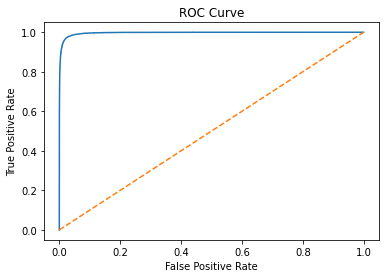

In [9]:
fpr, tpr, thr = roc_curve(y_val, y_preds, sample_weight=val_weights)

print("AUC Score:", roc_auc_score(y_val, y_preds, sample_weight=val_weights))
plt.title("ROC Curve")
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

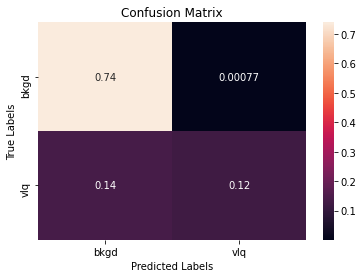

In [10]:
cm = confusion_matrix(y_val, y_preds.round(), normalize="all")

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.xaxis.set_ticklabels(["bkgd", "vlq"])
ax.yaxis.set_ticklabels(["bkgd", "vlq"])
plt.show()

# MCDropout

In [11]:
num_models = 100
mcpreds = []

for _ in tqdm(range(num_models), total=num_models, desc="MCDropout"):
    mcpreds.append(model.predict(X_val))
    
mcpreds = np.array(mcpreds)

MCDropout: 100%|██████████| 100/100 [05:04<00:00,  3.05s/it]


In [12]:
mc_means = mcpreds.mean(axis=0)
mc_stds = mcpreds.std(axis=0)

In [13]:
print("MCDropout Accuracy:", accuracy_score(mc_means.round(), y_val))

MCDropout Accuracy: 0.8629064996447885


MCDropout AUC Score: 0.9969424685219727


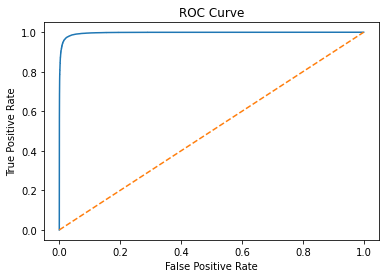

In [14]:
fpr, tpr, thr = roc_curve(y_val, mc_means, sample_weight=val_weights)

print("MCDropout AUC Score:", roc_auc_score(y_val, mc_means, sample_weight=val_weights))
plt.title("ROC Curve")
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

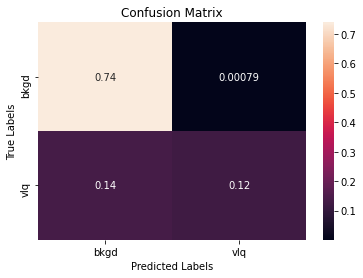

In [15]:
cm = confusion_matrix(y_val, mc_means.round(), normalize="all")

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.xaxis.set_ticklabels(["bkgd", "vlq"])
ax.yaxis.set_ticklabels(["bkgd", "vlq"])
plt.show()

# MCDropout STDs by class

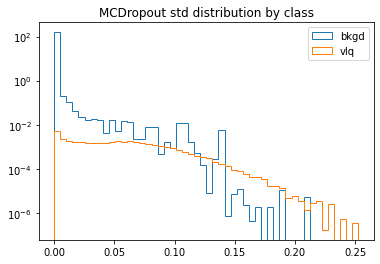

In [16]:
hist_min = min(mc_stds[y_val == 0].min(), mc_stds[y_val == 1].min())
hist_max = max(mc_stds[y_val == 0].max(), mc_stds[y_val == 1].max())
hist_range = (hist_min, hist_max)

plt.title("MCDropout std distribution by class")
plt.hist(mc_stds[y_val == 0], label="bkgd", bins=50, range=hist_range, histtype="step", weights=val_weights[y_val == 0])
plt.hist(mc_stds[y_val == 1], label="vlq", bins=50, range=hist_range, histtype="step", weights=val_weights[y_val == 1])
plt.yscale("log")
plt.legend()
plt.savefig("plots/mcdropout_std_distribution_by_class.png", dpi=500)
plt.show()

# MCDropout STDs by sample

In [44]:
# Gather sample names
samples = glob("data/dileptonic/*.csv")
samples += glob("data/sm_gluon_vlq/*.csv")
samples = [sample.split("/")[-1].split(".")[0] for sample in samples]

In [46]:
# Remove duplicate test and train samples
for i, sample in enumerate(samples):
    if "test" in sample:
        del samples[i]
        i -= 1
    elif "train" in sample:
        samples[i] = samples[i].replace("_train", "")

Por algum motivo é preciso efetuar este ciclo duas vezes

In [48]:
for i, sample in enumerate(samples):
    if "test" in sample:
        del samples[i]
    elif "train" in sample:
        samples[i] = samples[i].replace("_train", "")

In [49]:
samples

['ttbarZ_2L',
 'Zbj_2L',
 'Zbb_2L',
 'Zjj_2L',
 'ZZ_2L',
 'topWZ_2L',
 'topZj_2L',
 'ttbarW_2L',
 'topZj_2L',
 'WZ_2L',
 'ttbarb_2L',
 'ttbarZ_2L',
 'ttbarH_2L',
 'ttbar_2L',
 'ttbarj_2L',
 'WW_2L',
 'mch45_HG_13TeV_wohg_HQ1200',
 'mch45_HG_13TeV_wohg_HQ1400',
 'smg',
 'mch45_HG_13TeV_wohg_HQ1000']

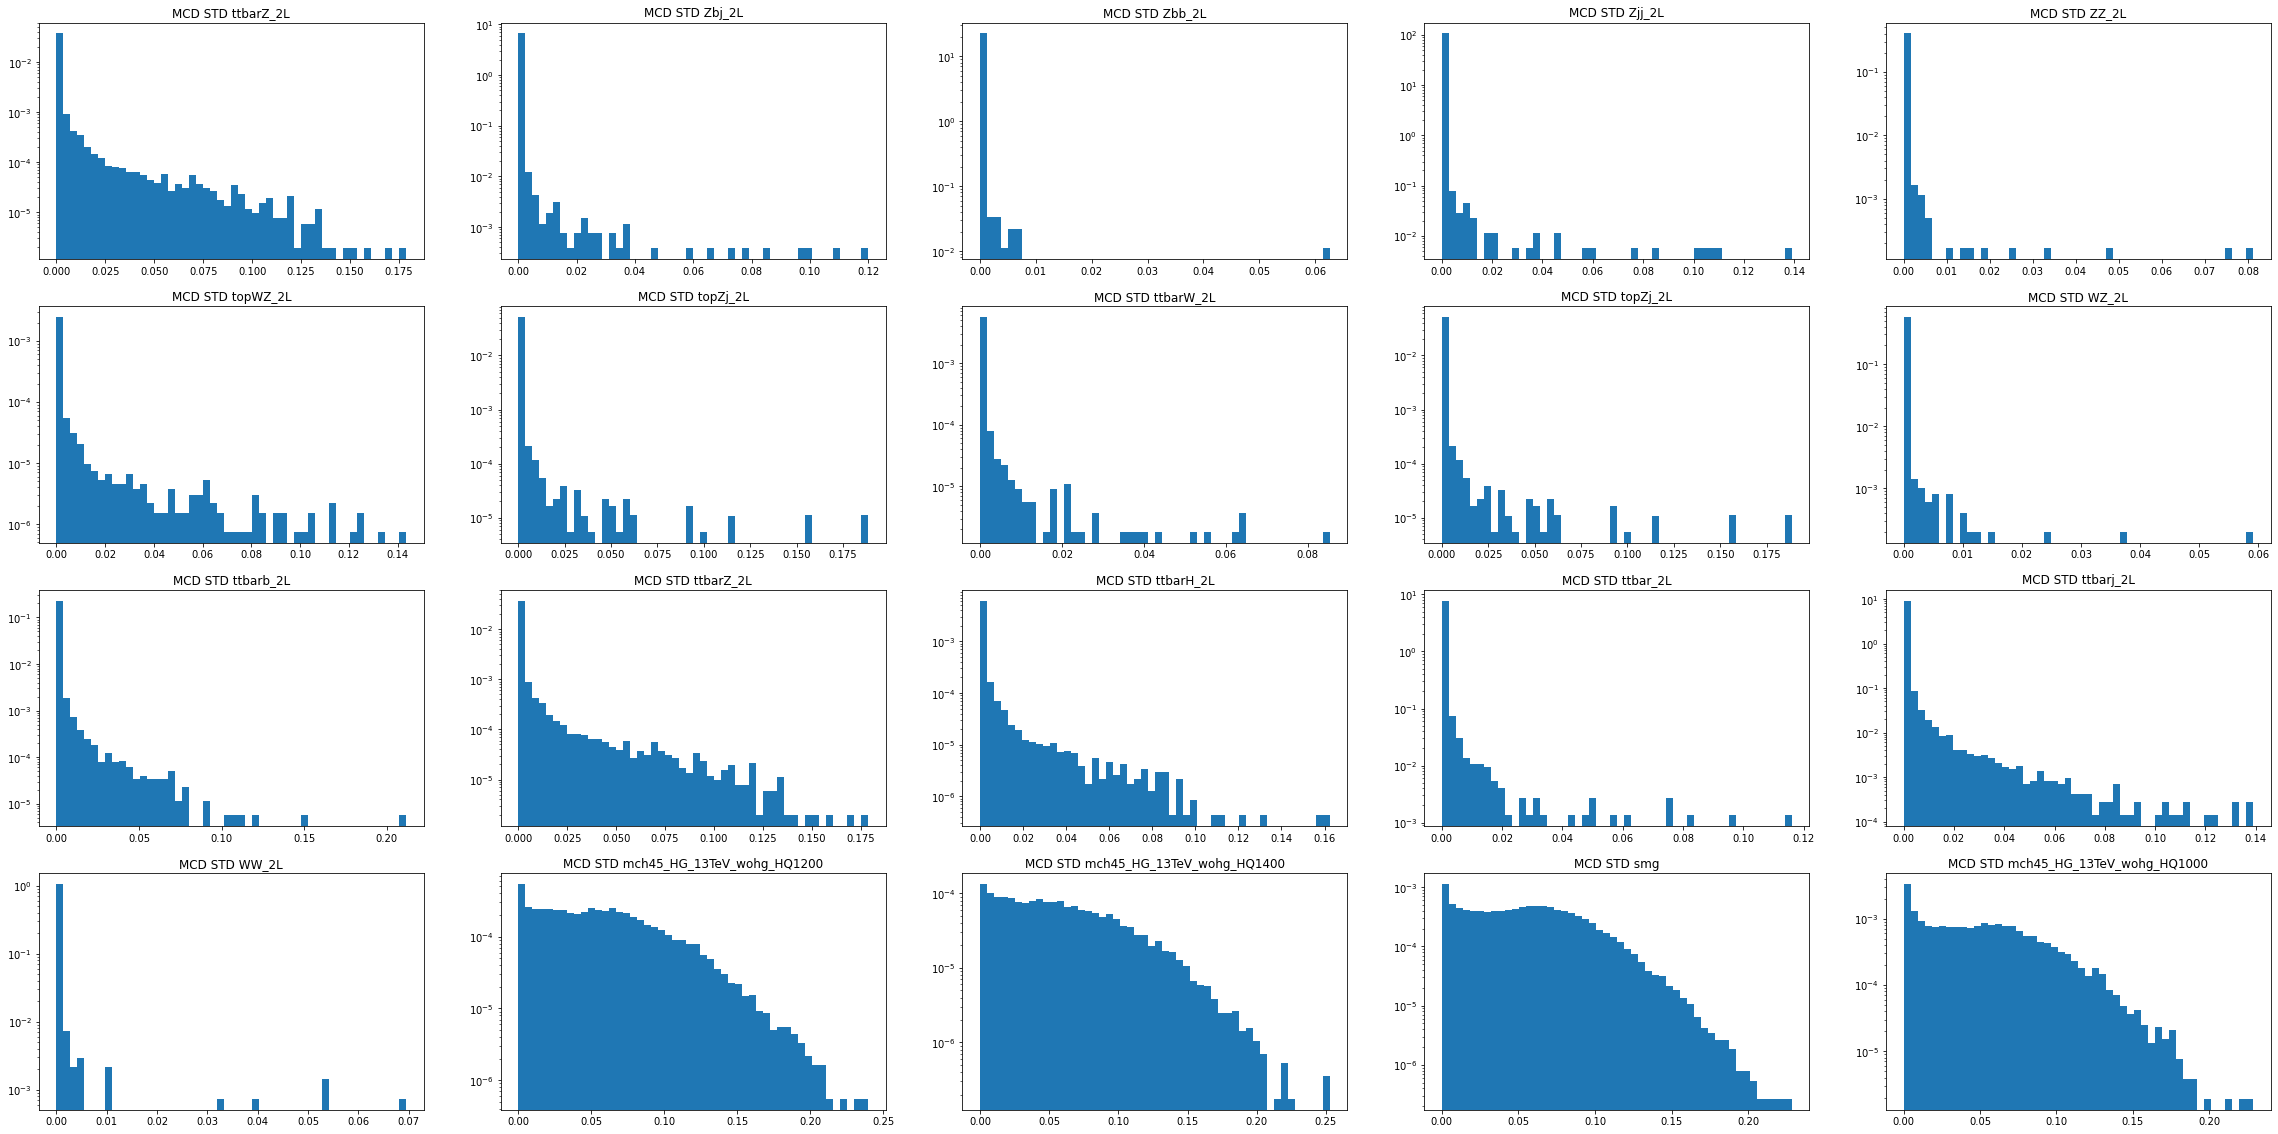

In [40]:
# Plot adjustment variables
num_cols, bins = 5, 50

# Generate the plots
num_rows = int(np.ceil((len(samples)) / num_cols))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(40, 20))

# Iterate and generate each data
for i, sample in enumerate(samples):
    # Plot the data
    row, col = int(i/num_cols), i%num_cols
    axs[row, col].set_title("MCD STD " + sample)
    axs[row, col].hist(mc_stds[val_samples == sample], bins=50, weights=val_weights[val_samples == sample])
    axs[row, col].set_yscale("log")
    
plt.savefig("plots/stds_distribution_mcd_per_sample.png", dpi=500)
plt.show()

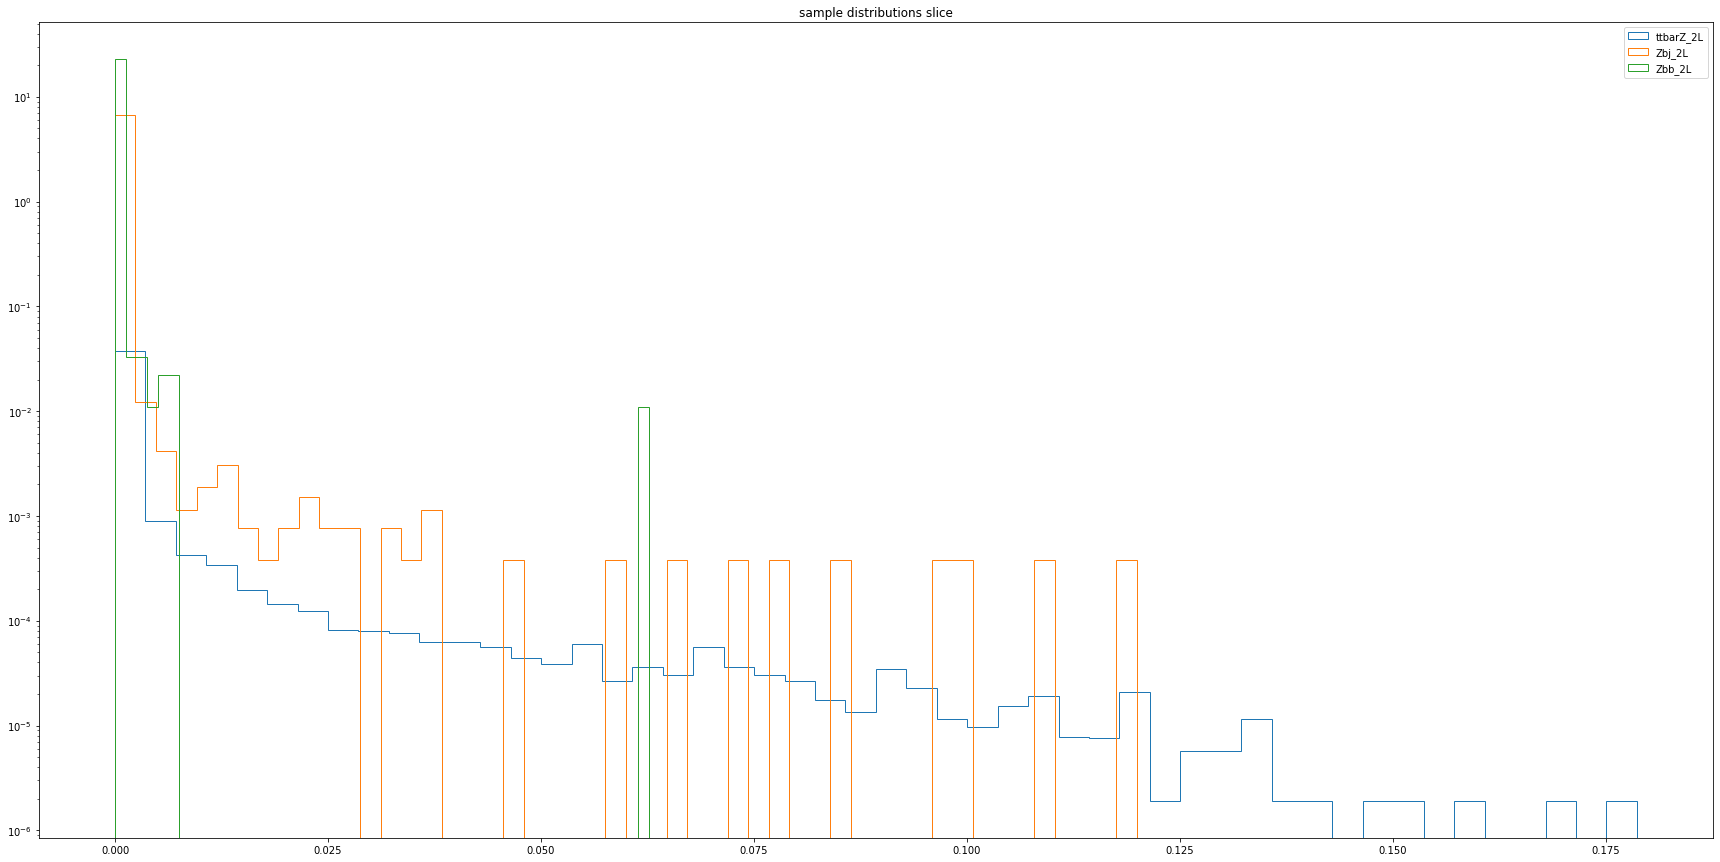

In [43]:
# Plot std distribution sample slices
start, end = 0, 3

plt.title("sample distributions slice")
for sample in samples[start:end]:
    plt.hist(mc_stds[val_samples == sample], weights=val_weights[val_samples == sample], bins=50, histtype="step", label=sample)
plt.gcf().set_size_inches(30, 15)
plt.yscale("log")
plt.legend()
plt.show()

# Std vs Means plot

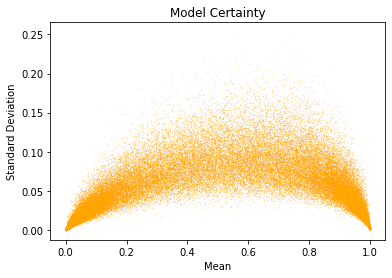

In [20]:
plt.title("Model Certainty")
plt.scatter(mc_means, mc_stds, s=0.01, color='orange')
plt.ylabel("Standard Deviation")
plt.xlabel("Mean")
plt.show()